In [26]:
import numpy as np
import matplotlib.pyplot as plt

from utils.file_manager import load_scan, windowing_image
from utils.plot_manager import show_mask
from curve_util import *

dcm_file = "D:/2차년도/골이식재양/한림대/2차년도 상악 54개/2-204 #24, #26/2-204 #24 #26 전CT 22.09.02"

_type, original_data, properties = load_scan(dcm_file)

tr_data = np.transpose(original_data, (2,1,0))
y = tr_data.shape[0]
top = bottom = 0
if _type == 1:
    top = y - 240
    bottom = y -140
    new_data = tr_data[top:bottom]
elif _type == 2:
    top = y-200
    bottom = y-100
    new_data = tr_data[top:bottom]
elif _type == 4:
    top = y-160
    bottom = y-60
    new_data = tr_data[top:bottom]
    

4 Tiles Stitching Data...


- 1 Tile = top-240 : top-140
- 2 Tiles Stitching = top-200 : top-100
- 4 Tiles Stitching = top-160 : top-60

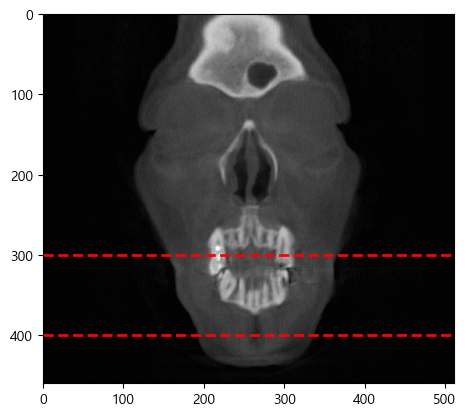

In [27]:
tmp_data = np.transpose(original_data, (1,2,0))
plt.imshow(tmp_data[120],'gray')
plt.axhline(top, 0, 1, color='red', linestyle='--', linewidth=2)
plt.axhline(bottom, 0, 1, color='red', linestyle='--', linewidth=2)

In [28]:
print(f"Window Center: {properties['window_center']}")
print(f"Window Width: {properties['window_width']}")

Window Center: 1024
Window Width: 4095


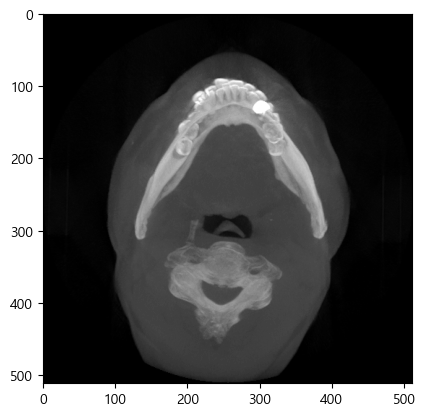

In [29]:
# Perform MIP along specified axis
mip_image = np.max(new_data, axis=0)
plt.imshow(mip_image, 'gray')

### Windowing and Normalize
---

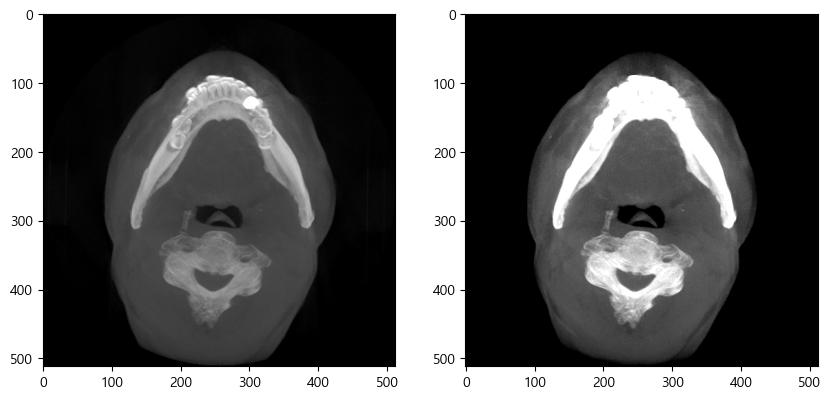

In [30]:
window_image = windowing_image(mip_image, properties, use_normalize=True)
bone_image = windowing_image(mip_image, properties,window=(400,1800), use_normalize=True)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(window_image, 'gray')
ax[1].imshow(bone_image, 'gray')

### Apply gamma
---

In [31]:
# def plot_gamma_curves(gammas=[0.5, 1.0, 2.0]):
#     """
#     감마 변환 곡선을 시각화하는 함수
#     """
#     x = np.linspace(0, 1, 256)
    
#     plt.figure(figsize=(8, 6))
#     for gamma in gammas:
#         y = gamma_correction(x, gamma)
#         plt.plot(x, y, label=f'γ = {gamma}')
    
#     plt.plot([0, 1], [0, 1], '--', color='gray', label='Original')
#     plt.xlabel('Input Intensity')
#     plt.ylabel('Output Intensity')
#     plt.title('Gamma Correction Curves')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
# # 감마 변환 곡선 시각화
# plot_gamma_curves()


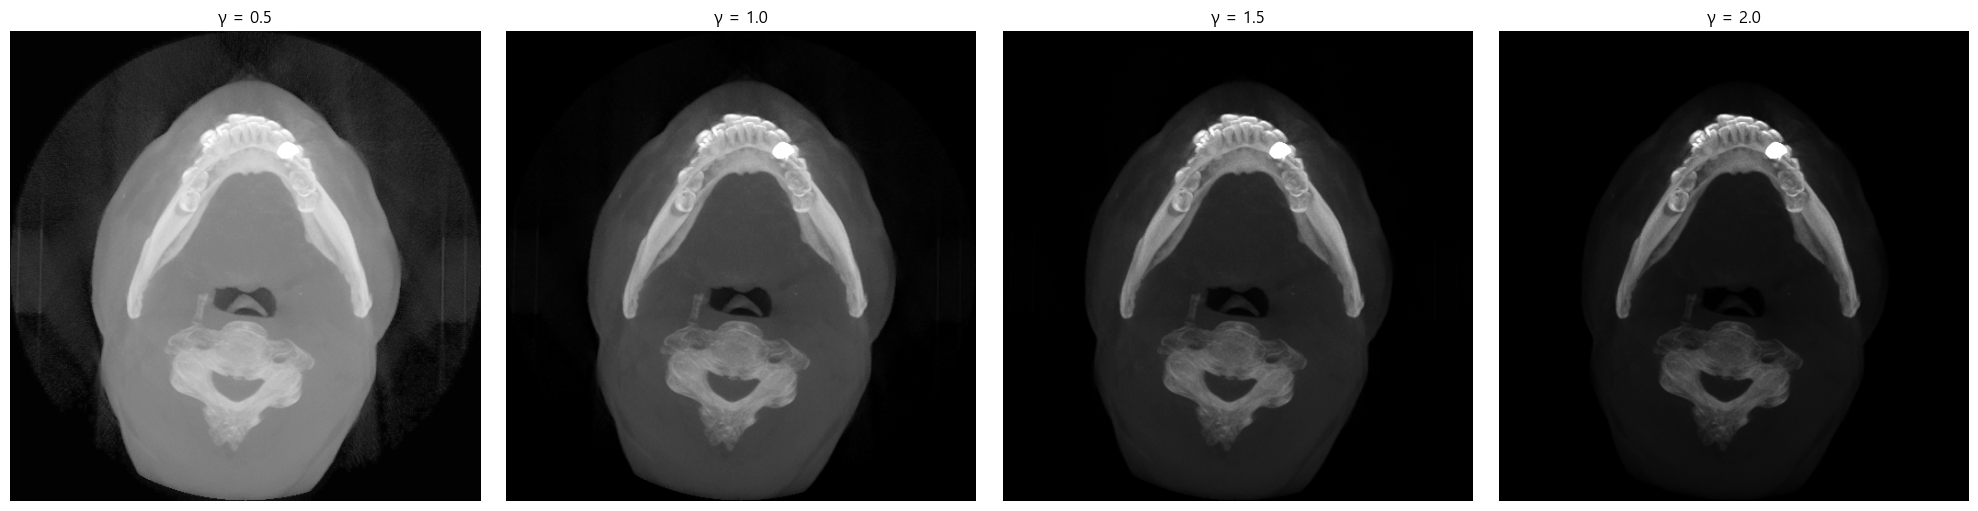

In [32]:
def visualize_gamma_effect(image, gammas=[0.5, 1.0, 1.5, 2.0]):
    """
    다양한 감마 값의 효과를 시각화하는 함수
    
    Parameters:
    -----------
    image : numpy.ndarray
        입력 이미지
    gammas : list of float
        테스트할 감마 값들의 리스트
    """
    fig, axes = plt.subplots(1, len(gammas), figsize=(5*len(gammas), 5))
    
    for ax, gamma in zip(axes, gammas):
        corrected = gamma_correction(image, gamma)
        ax.imshow(corrected, cmap='gray')
        ax.set_title(f'γ = {gamma}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
# 다양한 감마 값의 효과 시각화
visualize_gamma_effect(window_image)


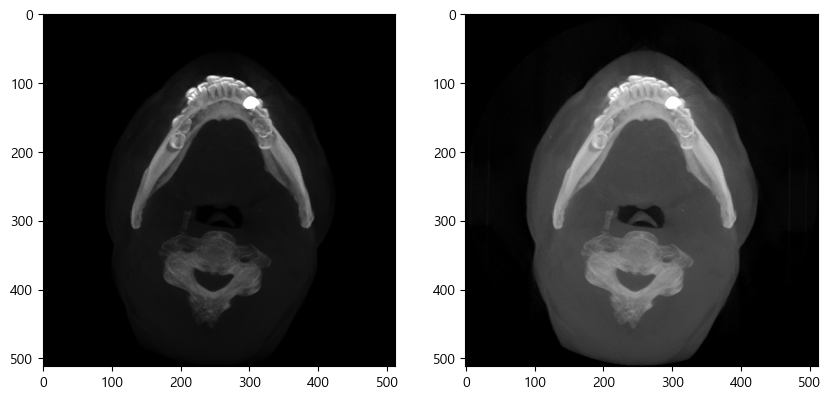

In [33]:
test_image = gamma_correction(window_image, gamma=2.0)
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(test_image,'gray')
ax[1].imshow(window_image, 'gray')

## Binarization
---

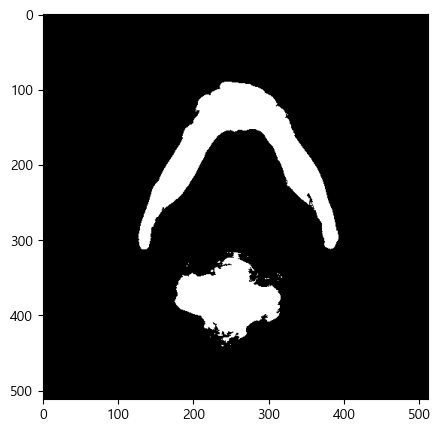

In [34]:
midle_point = (int(test_image.shape[0] / 2), int(test_image.shape[1] / 2))
seed_points = ([(0,0), midle_point])
binary_region = region_growing_binary(test_image, seed_points=seed_points, threshold=0.2)
# binary_region = invert_binary_image(binary_region)
# cleaned_binary = ~post_process_binary(binary_region, min_size=100)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(binary_region, 'gray')

### Segmented arch area
---

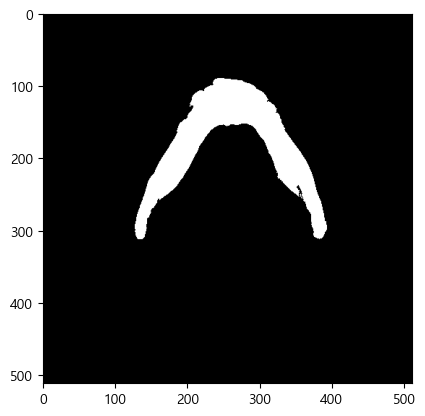

In [35]:
result, max_len = find_largest_component(binary_region)
plt.imshow(result, 'gray')

### The arch area after morphological
---

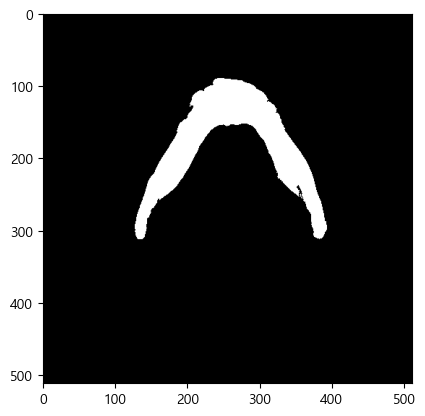

In [36]:
import scipy.ndimage as ndi
result_10 = ndi.binary_fill_holes(result)
# result_10 = fill_holes(result)
plt.imshow(result_10, 'gray')

### Apply Gaussian Filter
---

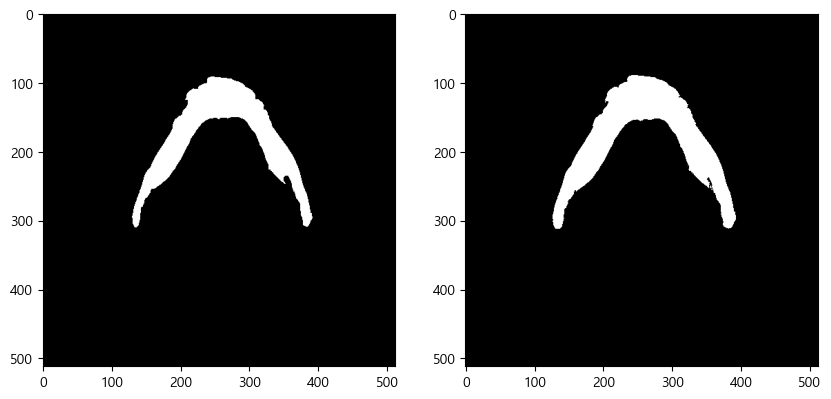

In [37]:

result_12 = smooth_edges(result_10, sigma=2.0, edge_width=2, iterations=2)
# result_12 = gaussian(result_10, sigma=2.0, mode="wrap")
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(result_12, 'gray')
ax[1].imshow(result_10, 'gray')

### skeletonize
---

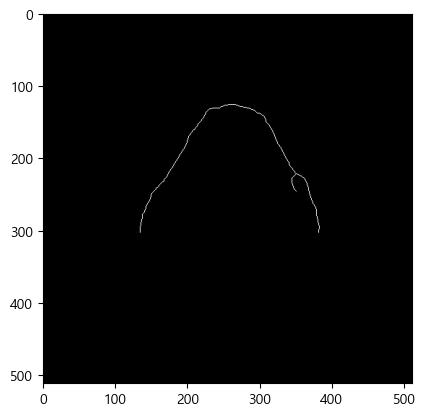

In [38]:
skeleton = extract_skeleton(result_12)
plt.imshow(skeleton, 'gray')

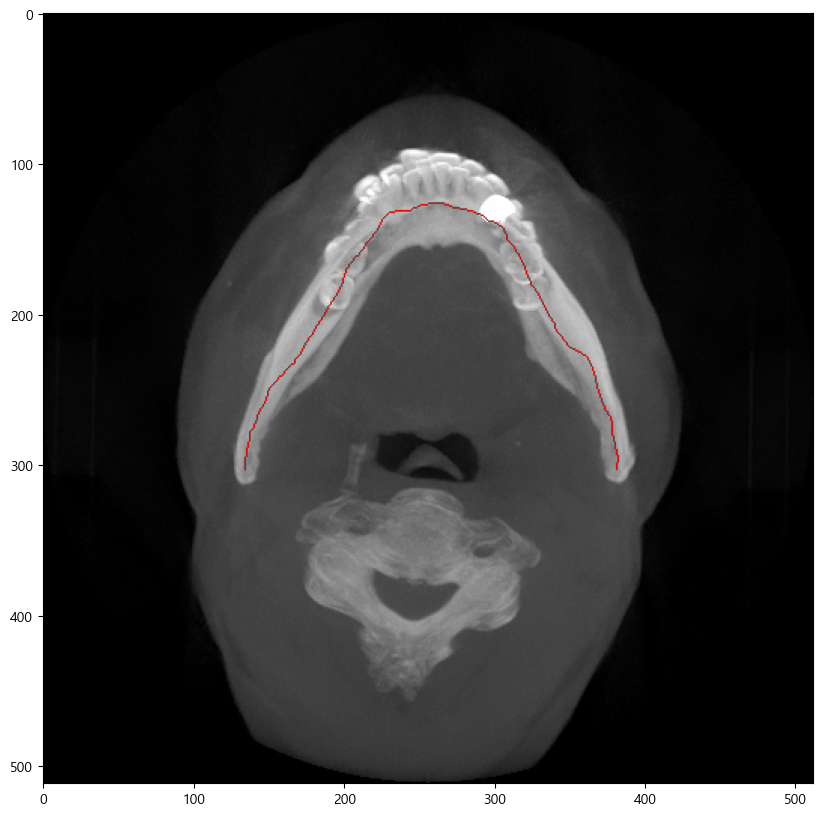

In [39]:
curve = find_longest_path(skeleton)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(mip_image, 'gray')
show_mask(curve, ax)

In [41]:
def visualize_results(binary_image, x_smooth, y_smooth):
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 나눔고딕 폰트 사용
    plt.rcParams['axes.unicode_minus'] = False    # 마이너스 기호 깨짐 방지
    """
    원본 이진 이미지와 부드러워진 선을 시각화합니다.
    """
    plt.figure(figsize=(12, 6))
    
    # 원본 이미지
    plt.subplot(121)
    plt.imshow(binary_image, cmap='gray')
    plt.title('원본 이미지')
    plt.axis('image')
    
    # 부드러워진 선
    plt.subplot(122)
    plt.imshow(binary_image, cmap='gray', alpha=0.3)
    plt.plot(x_smooth, y_smooth, 'r-', linewidth=2)
    plt.title('부드러워진 선')
    plt.axis('image')
    
    plt.tight_layout()
    plt.show()

In [47]:
x_smooth, y_smooth = smooth_binary_line(curve, num_points=11)
len(x_smooth), len(y_smooth)

(11, 11)

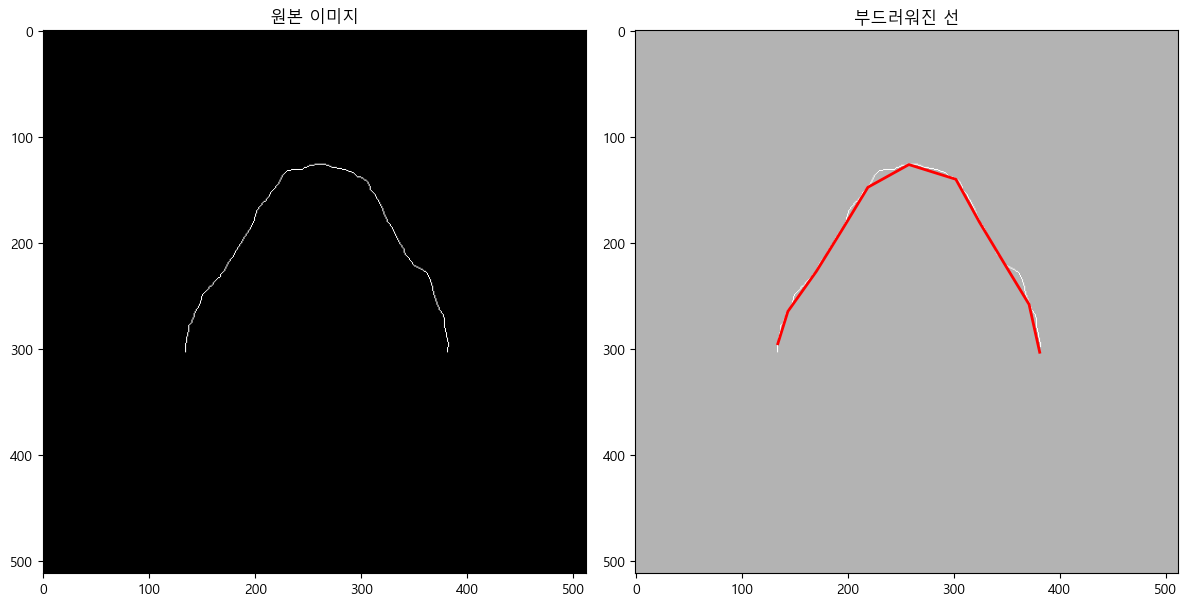

In [48]:
visualize_results(curve, x_smooth, y_smooth)

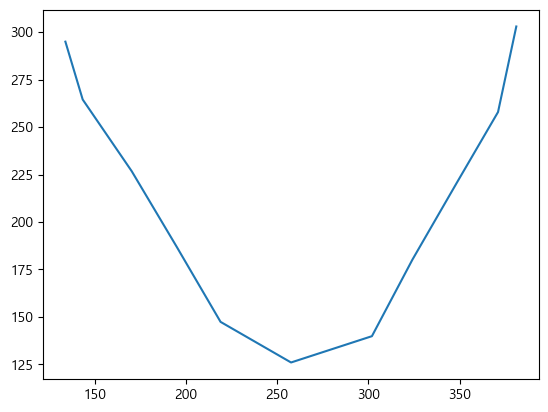

In [49]:
plt.plot(x_smooth, y_smooth)

In [45]:
import matplotlib.font_manager as fm
def setup_fonts():
    """
    사용 가능한 한글 폰트를 찾아 설정합니다.
    """
    # 시스템에 설치된 폰트 목록
    font_list = [f.name for f in fm.fontManager.ttflist]
    
    # 선호하는 한글 폰트 목록
    korean_fonts = ['NanumGothic', 'Malgun Gothic', 'AppleGothic', 'NanumBarunGothic']
    
    # 설치된 한글 폰트 찾기
    for font in korean_fonts:
        if font in font_list:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            print(f"Using font: {font}")
            return True
    
    # 한글 폰트를 찾지 못한 경우 영문 폰트 사용
    print("No Korean font found. Using default font.")

In [46]:
setup_fonts()

Using font: Malgun Gothic


True